# Orbit Propagation Analysis for SWARM B: SGP4, Keplerian, EcksteinHeckler, Numerical Propagator and CPF Validation

This notebook performs a comparison of orbit propagation methods for the satellite SWARM B (NID 39451). 

Orbit Propagation Methods:

- **SGP4 Propagation:** Utilizes TLE (Two-Line Element) data for orbit prediction.

- **Keplerian Propagation:** Uses orbital elements to predict the satellite’s position and velocity.

- **EcksteinHeckler Propagation:** Applies a geopotential model for more accurate orbit predictions.

- **Numerical Propagator:** Uses precise numerical integration methods for high-fidelity orbit prediction.

Validation Data:

- **CPF (Consolidated Prediction Format) Data:** Provides precise satellite ephemerides used as a reference to validate and benchmark the accuracy of the different propagation models.

The analysis focuses on the accuracy and performance of each method. 

The notebook integrates ephemeris data and uses Orekit's Python wrapper for computations, aiming to evaluate different propagation approaches and their suitability for precise satellite tracking.

## Orekit Environment Setup

In [4]:
import orekit
vm = orekit.initVM()

from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

from org.orekit.orbits import KeplerianOrbit, PositionAngleType, OrbitType, CartesianOrbit, Orbit
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint, CelestialBodyFactory
from org.orekit.time import TimeScalesFactory, AbsoluteDate, DateComponents, TimeComponents
from org.orekit.utils import IERSConventions, Constants, PVCoordinates, PVCoordinatesProvider
from org.orekit.propagation import SpacecraftState
from org.orekit.propagation.numerical import NumericalPropagator
from org.orekit.propagation.analytical.tle import TLE, TLEPropagator
from org.orekit.propagation.analytical import KeplerianPropagator, EcksteinHechlerPropagator
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel, ThirdBodyAttraction
from org.orekit.forces.drag import DragForce, DragSensitive, IsotropicDrag     
from org.orekit.forces.radiation import SolarRadiationPressure, IsotropicRadiationClassicalConvention
from org.orekit.models.earth.atmosphere import JB2008, NRLMSISE00, DTM2000
from org.orekit.models.earth.atmosphere.data import CssiSpaceWeatherData

from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator

from math import radians, degrees, pi, sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import linecache

from java.util import Arrays
from orekit import JArray_double

## Time and Reference Frame Configuration

In [6]:
UTC = TimeScalesFactory.getUTC()
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
TEME = FramesFactory.getTEME()
ECI = FramesFactory.getEME2000()
R_earth = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
Mu_earth = Constants.WGS84_EARTH_MU
F_earth = Constants.WGS84_EARTH_FLATTENING

satellite_mass = 473.0 # kg                               # Input the required satellite mass.

earth = OneAxisEllipsoid(R_earth, F_earth, ITRF)          # Define earth body for later use.

### step_size: 180 sec.
initialDate = AbsoluteDate(2022, 7, 4, 0, 0, 0.0, UTC) ### ephemeris_start:2022-07-04 00:00:00 UTC 
finalDate = AbsoluteDate(2022, 7, 7, 0, 0, 0.0, UTC)   ### ephemeris_stop:2022-07-07 00:00:00 UTC

## Initial Orbit

In [8]:
#SWARM B 39451
tle_line1 = "1 39451U 13067A   22184.92713060  .00000940  00000-0  41402-4 0  9992"
tle_line2 = "2 39451  87.7497  56.3866 0002579  92.5740 267.5801 15.20530726463430"
mytle = TLE(tle_line1,tle_line2)

initialDateSGP4 = mytle.getDate()              # This is the TLE epoch date read from first line.
print(initialDateSGP4)

SGP4 = TLEPropagator.selectExtrapolator(mytle)            # SGP4 propagator from Orekit

pos = []                                                  # pos vector to be filled.
SGP4 = PVCoordinatesProvider.cast_(SGP4)

2022-07-03T22:15:04.08384Z


## Initial Keplerian Orbital Elements  


In [10]:
# Initial date was previously iterated. Therefore, it must be restored.
initialDate = AbsoluteDate(2022, 7, 4, 0, 0, 0.0, UTC)
TLE_pv = SGP4.getPVCoordinates(initialDate, ECI)
pos = TLE_pv.getPosition()
print(pos)
vel = TLE_pv.getVelocity()
print(vel)

# Initial date was previously iterated. Therefore, it must be restored.
initialDate = AbsoluteDate(2022, 7, 4, 0, 0, 0.0, UTC)

initialOrbit = CartesianOrbit(TLE_pv, ECI, initialDate, Mu_earth)
initialState = SpacecraftState(initialOrbit, satellite_mass)             # Mass is not necessary. 
keplerElements = OrbitType.KEPLERIAN.convertType(initialState.getOrbit())
print(keplerElements)


a = keplerElements.getA()          # Semi-major Axis (m)
e = keplerElements.getE()           # Eccentricity 
i = keplerElements.getI()            # Inclination
omega = radians(113.97576318775434)   # Argument of Perigee
raan = radians(56.08067794583404)      # RAAN           
lv = radians(-75.40167184562995)        # True Anomaly                      

# Orbit construction as Keplerian
satellite_mass = 473.0 # kg

initialOrbit = KeplerianOrbit(a, e, i, omega, raan, lv, PositionAngleType.TRUE, 
                              ECI, initialDate, Mu_earth)
initialState = SpacecraftState(initialOrbit, satellite_mass)

{2,867,507.5271674157; 4,552,245.003776637; 4,285,971.358993142}
{-2,839.0980642396; -3,822.6534011481; 5,941.1863611521}
Keplerian parameters: {a: 6881317.509375315; e: 0.0015600542702036886; i: 87.85220718335508; pa: 113.97576318775434; raan: 56.08067794583404; v: -75.40167184562995;}


# Analytical Propagators

## SGP4 Propagator

In [13]:
SGP4 = TLEPropagator.selectExtrapolator(mytle)            # SGP4 propagator from Orekit

pos = []                                                  # pos vector to be filled.
SGP4 = PVCoordinatesProvider.cast_(SGP4)
###Start SGP4 propagation from initialDate up until finalDate
while (initialDate.compareTo(finalDate) <= 0.0):
    SGP4_pv = SGP4.getPVCoordinates(initialDate, ITRF)    # Get PV coordinates
    posSGP4 = SGP4_pv.getPosition()                       # But we only want position vector.
    pos.append((posSGP4.getX(),posSGP4.getY(),posSGP4.getZ())) # Get individual elements of position
    posSGP4 = pos
    initialDate = initialDate.shiftedBy(180.0)            # Propagate with 180 sec intervals.

# Below block is just for data acquisition  
array = []
for i in range(0,len(posSGP4)):
    str_converted = str(posSGP4[i])
    float_converted = [float(s) for s in re.findall(r'-?\d+\.?\d*', str_converted)]
    array = np.append(array,float_converted)

# This is the SGP4 result in array format for each time step.     
SGP4pos = array.reshape((len(posSGP4), 3)) 

## Keplerian Propagator

In [15]:
# Initial date was previously iterated. Therefore, it must be restored.
initialDate = AbsoluteDate(2022, 7, 4, 0, 0, 0.0, UTC)

keplerPropagator = KeplerianPropagator(initialOrbit)  # Keplerian propagator from Orekit

pos = []                                                                 # pos vector to be filled.
keplerPropagator = PVCoordinatesProvider.cast_(keplerPropagator)
### Start Keplerian propagation from initialDate up until finalDate
while (initialDate.compareTo(finalDate) <= 0.0):
    Keplerprop_pv = keplerPropagator.getPVCoordinates(initialDate, ITRF)  # Get PV coordinates
    posKepler = Keplerprop_pv.getPosition()                              # But we only want position vector.
    pos.append((posKepler.getX(),posKepler.getY(),posKepler.getZ()))     # Get individual elements of position vector.
    posKepler = pos  
    initialDate = initialDate.shiftedBy(180.0)                            # Propagate with 60 sec intervals.

# Below block is just for data acquisition  
array = []
for i in range(0,len(posKepler)):
    str_converted = str(posKepler[i])
    float_converted = [float(s) for s in re.findall(r'-?\d+\.?\d*', str_converted)]
    array = np.append(array,float_converted)
    
# This is the Kepler propagator result in array format for each time step.    
Keplerpos = array.reshape((len(posKepler), 3))

## EcksteinHeckler Propagator

In [17]:
# Initial date was previously iterated. Therefore, it must be restored.
initialDate = AbsoluteDate(2022, 7, 4, 0, 0, 0.0, UTC)

# EcksteinHeckler propagator from Orekit
propagator_eh = EcksteinHechlerPropagator(initialOrbit, 
                                        Constants.EIGEN5C_EARTH_EQUATORIAL_RADIUS,
                                        Constants.EIGEN5C_EARTH_MU, Constants.EIGEN5C_EARTH_C20,
                                        Constants.EIGEN5C_EARTH_C30, Constants.EIGEN5C_EARTH_C40,
                                        Constants.EIGEN5C_EARTH_C50, Constants.EIGEN5C_EARTH_C60)

pos = []                                                         # pos vector to be filled.
propagator_eh = PVCoordinatesProvider.cast_(propagator_eh)
### Start EcksteinHeckler propagation from initialDate up until finalDate.
while (initialDate.compareTo(finalDate) <= 0.0):
    EHprop_pv = propagator_eh.getPVCoordinates(initialDate, ITRF) # Get PV coordinates
    posEH = EHprop_pv.getPosition()                              # But we only want position vector.
    pos.append((posEH.getX(),posEH.getY(),posEH.getZ()))         # Get individual elements of position vector.
    posEH = pos
    initialDate = initialDate.shiftedBy(180.0)                    # Propagate with 60 sec intervals.
    
# Below block is just for data acquisition        
array = []
for i in range(0,len(posEH)):
    str_converted = str(posEH[i])
    float_converted = [float(s) for s in re.findall(r'-?\d+\.?\d*', str_converted)]
    array = np.append(array,float_converted) 
    
# This is the EcksteinHeckler propagator result in array format for each time step.       
EHpos = array.reshape((len(posEH), 3))

# Numerical Propagator

In [19]:
minStep = 0.001;                    # Define min. step for numerical propagator.
maxstep = 1000.0;                   # Define max. step for numerical propagator.
initStep = 60.0                     # Define the initial step size for numerical propagator.
positionTolerance = 1.0 

tol = NumericalPropagator.tolerances(positionTolerance, initialOrbit, OrbitType.CARTESIAN)

# Select the desired integrator. In this case DormandPrince853 Integrator is chosen.
integrator = DormandPrince853Integrator(minStep, maxstep, 
    JArray_double.cast_(tol[0]),  # Double array of doubles needs to be casted in Python
    JArray_double.cast_(tol[1]))
integrator.setInitialStepSize(initStep)

# Numerical propagator is set up in below lines.
propagator_num = NumericalPropagator(integrator)
propagator_num.setOrbitType(OrbitType.CARTESIAN)    
propagator_num.setInitialState(initialState)  

In [20]:
### Different perturbation models have to be defined in numerical propagation.
# Call different celestial bodies to account their attraction effects.
sun = CelestialBodyFactory.getSun()      # Call Sun
moon = CelestialBodyFactory.getMoon()    # Call Moon
gravityProvider = GravityFieldFactory.getNormalizedProvider(150, 150) # Gprovider should get models.

# Add atmospheric effects and define the drag force.
CSWD = CssiSpaceWeatherData("SpaceWeather-All-v1.2.txt")     # Weather data must be read from txt. file located in the same directory.
atmosphere = DTM2000(CSWD, sun, earth)                       # DTM2000 atmospheric model is selected.
drag_force = DragForce(atmosphere, IsotropicDrag(5.0, 0.1))  # Find the drag force (cross-section, cd)

# Finally, add all the called models to our numerical propagator.
propagator_num.addForceModel(HolmesFeatherstoneAttractionModel(earth.getBodyFrame(), gravityProvider))  ### Gravity 
propagator_num.addForceModel(ThirdBodyAttraction(sun))        # Sun attraction
propagator_num.addForceModel(ThirdBodyAttraction(moon))       # Moon attraction
propagator_num.addForceModel(drag_force)                      # DragAtmospheric model

In [21]:
# Initial date was previously iterated. Therefore, it must be restored.
initialDate = AbsoluteDate(2022, 7, 4, 0, 0, 0.0, UTC)

pos = []                                              # pos vector to be filled.
propagator_num = PVCoordinatesProvider.cast_(propagator_num)
### Start Numerical propagation from initialDate up until finalDate
while (initialDate.compareTo(finalDate) <= 0.0):
    Numprop_pv = propagator_num.getPVCoordinates(initialDate, ITRF) # Get PV coordinates
    posNum = Numprop_pv.getPosition()                              # But we only want position vector
    pos.append((posNum.getX(),posNum.getY(),posNum.getZ()))        # Get individual elements of position vector.
    initialDate = initialDate.shiftedBy(180.0)                      # Propagate with 60 sec intervals.

# Below block is just for data acquisition 
array = []
for i in range(0,len(pos)):
    str_converted = str(pos[i])
    float_converted = [float(s) for s in re.findall(r'-?\d+\.?\d*', str_converted)]
    array = np.append(array,float_converted)  

# This is the Numerical propagator result in array format for each time step.  
Numpos = array.reshape((int(len(array)/3), 3))

## Reading the "true" ephemeris data from CDDIS 

In [23]:
# Swarm A ephemeris data obtained from CDDIS.
# To access this data you must first log in to CDDIS!
# https://cddis.nasa.gov/archive/slr/cpf_predicts_v2/current/

datafile = open("swarmb_cpf_220704_18501.txt", "r")

array = []                      # array vector to be filled.

for i in range(3, 2405, 1):    # range(starting_line, final_line, increment)
    particular_line = linecache.getline('swarmb_cpf_220704_18501.txt', i)
    a = particular_line.split('      ')
    pv = a[1:4]
    pv = [float(s) for s in pv]
    array = np.append(array,pv)

# This is the position data gathered from CDDIS, which will be used as truth data (assumed truth data).    
SwarmApos = array.reshape(int(len(array)/3), 3)

# Add one more data point if necessary to ensure that slicing to 60% works correctly
if len(SwarmApos) % 2 != 0:  # Check if the length is odd
    # Add a new row of zeros (or any placeholder value) to make the length even
    new_data = np.zeros((1, 3))  # Create a new row with zeros
    SwarmApos = np.vstack([SwarmApos, new_data])  # Append the new row to the array

# Extract the first 60% of the data
SwarmApos = SwarmApos[:int(0.6 * len(SwarmApos))]

print(len(SwarmApos))

1441


# Error Analysis

##  Position Magnitude Errors 

### SGP4 - Position Magnitude Error 

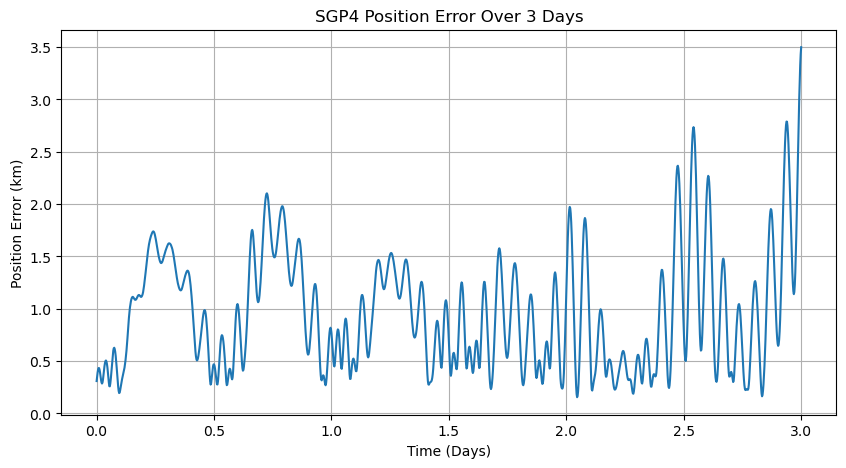

In [27]:
diff = np.subtract(SGP4pos, SwarmApos)
square=np.square(diff)
array = []
for i in range(0, len(square)):
    addition = square[i,0]+square[i,1]+square[i,2]
    mag_diff = np.sqrt(addition)
    array = np.append(array,mag_diff)
mag_diff = array.reshape((1441, 1)) 

# Assuming `error_data` contains the 2401 points of error values
time_steps = np.arange(0, 1441) * 180  # 180-second step size

# Convert time steps to days for the x-axis
time_days = time_steps / 86400  # Convert seconds to days

# Plot with days on the x-axis
plt.figure(figsize=(10, 5))
plt.plot(time_days, mag_diff/1000)
plt.xlabel("Time (Days)")
plt.ylabel("Position Error (km)")
plt.title("SGP4 Position Error Over 3 Days")
plt.grid(True)
plt.show()

The SGP4 propagator tends to show moderate position magnitude errors. These errors may remain relatively stable initially but can grow over time due to accumulated inaccuracies in the simplified model.

The error is primarily due to SGP4's inability to model higher-order perturbative effects such as non-spherical Earth gravity terms beyond J2, atmospheric drag variations, and solar radiation pressure effects. While SGP4 does account for some of these factors to a degree, it cannot match the detailed modeling capabilities of more complex numerical methods.

Over time, the SGP4 model's simplifications lead to an increasing error, especially over periods of weeks or months. This error becomes more significant for satellites experiencing high drag or when there are orbital maneuvers that the model cannot account for.

### Keplerian Propagator - Position Magnitude Error  

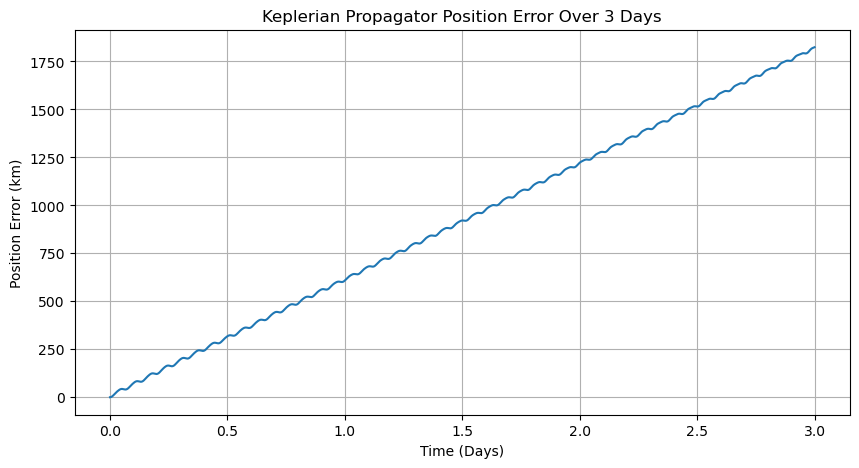

In [30]:
diff = np.subtract(Keplerpos, SwarmApos)
square=np.square(diff)
array = []
for i in range(0, len(square)):
    addition = square[i,0]+square[i,1]+square[i,2]
    mag_diff = np.sqrt(addition)
    array = np.append(array,mag_diff)
mag_diff = array.reshape((1441, 1)) 


# Assuming `error_data` contains the 2401 points of error values
time_steps = np.arange(0, 1441) * 180  # 180-second step size

# Convert time steps to days for the x-axis
time_days = time_steps / 86400  # Convert seconds to days

# Plot with days on the x-axis
plt.figure(figsize=(10, 5))
plt.plot(time_days, mag_diff/1000)
plt.xlabel("Time (Days)")
plt.ylabel("Position Error (km)")
plt.title("Keplerian Propagator Position Error Over 3 Days")
plt.grid(True)
plt.show()



The position magnitude error in the Keplerian propagator is typically larger than that of SGP4, especially for longer prediction periods. This is because the Keplerian model assumes a simple elliptical orbit without any perturbations.

The Keplerian model does not account for atmospheric drag, non-spherical Earth effects, third-body influences (e.g., the Moon or Sun), or solar radiation pressure. As a result, the error in the estimated position grows as these unmodeled forces deviate the actual path from the idealized elliptical orbit.

The position magnitude error increases steadily over time as these unaccounted perturbations accumulate. For satellites in low Earth orbit, this growth can be rapid due to atmospheric drag. For those in higher orbits, it may be slower but still significant due to gravitational perturbations.

### Eckstein-Heckler Propagator - Position Magnitude Error  

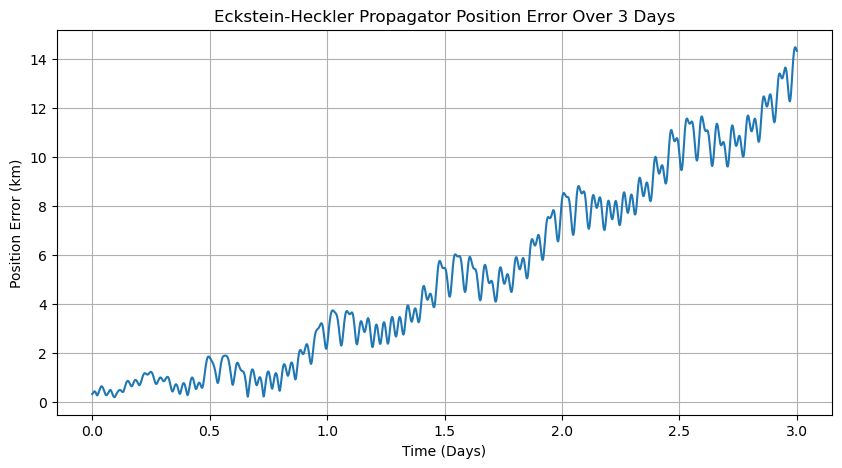

In [33]:
diff = np.subtract(EHpos, SwarmApos)
square=np.square(diff)
array = []
for i in range(0, len(square)):
    addition = square[i,0]+square[i,1]+square[i,2]
    mag_diff = np.sqrt(addition)
    array = np.append(array,mag_diff)
mag_diff = array.reshape((1441, 1)) 

# Assuming `error_data` contains the 2401 points of error values
time_steps = np.arange(0, 1441) * 180  # 180-second step size

# Convert time steps to days for the x-axis
time_days = time_steps / 86400  # Convert seconds to days

# Plot with days on the x-axis
plt.figure(figsize=(10, 5))
plt.plot(time_days, mag_diff/1000)
plt.xlabel("Time (Days)")
plt.ylabel("Position Error (km)")
plt.title("Eckstein-Heckler Propagator Position Error Over 3 Days")
plt.grid(True)
plt.show()

The Eckstein-Hechler propagator offers a lower position magnitude error compared to Keplerian, particularly for near-circular orbits where it is designed to perform well. Its errors are smaller due to better handling of the Earth's gravitational field.

It includes higher-order gravity models (e.g., J2, J3, J4 terms), which help reduce errors from Earth's non-spherical shape. However, it still lacks a detailed atmospheric drag model and does not account for solar radiation pressure or third-body influences.

The position magnitude error remains relatively low for a while but can still increase over time due to unmodeled forces like drag and third-body effects.

### Numerical Propagator - Position Magnitude Error

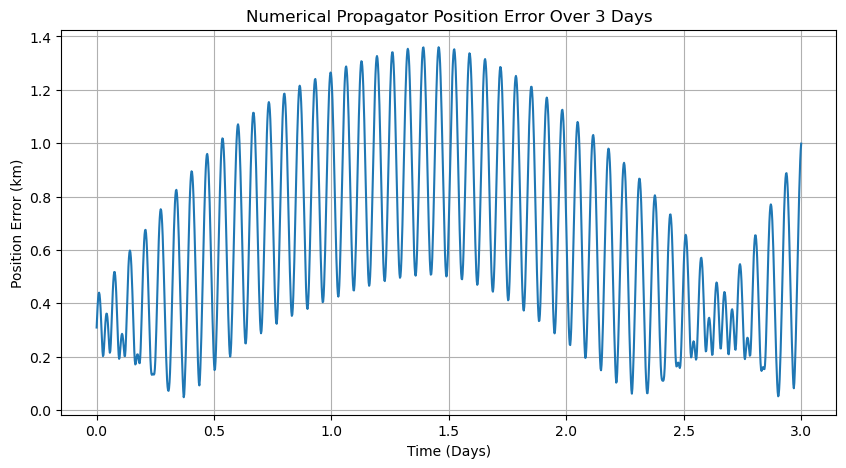

In [36]:
diff = np.subtract(Numpos, SwarmApos)
square = np.square(diff)
array = []
for i in range(0, len(square)):
    addition = square[i,0]+square[i,1]+square[i,2]
    mag_diff = np.sqrt(addition)
    array = np.append(array,mag_diff)
mag_diff = array.reshape((1441, 1)) 

# Assuming `error_data` contains the 2401 points of error values
time_steps = np.arange(0, 1441) * 180  # 180-second step size

# Convert time steps to days for the x-axis
time_days = time_steps / 86400  # Convert seconds to days

# Plot with days on the x-axis
plt.figure(figsize=(10, 5))
plt.plot(time_days, mag_diff/1000)
plt.xlabel("Time (Days)")
plt.ylabel("Position Error (km)")
plt.title("Numerical Propagator Position Error Over 3 Days")
plt.grid(True)
plt.show()

The numerical propagator typically exhibits the smallest position magnitude error among the compared methods. It aims for high precision by directly solving the equations of motion with detailed force models.

Errors in the numerical propagator are generally due to differences in initial conditions or minor mismatches in the exact models used between the CPF data and the propagator itself. For instance, slight variations in how atmospheric drag or gravitational fields are modeled can cause these small deviations.

The position magnitude error remains small even over extended time periods, making it ideal for precise orbit determination and prediction tasks. While small residual errors may accumulate, they are significantly less than those seen with simpler models due to the detailed consideration of perturbative effects like atmospheric drag, solar radiation pressure, and third-body gravitational influences.

##  Root Mean Square Errors (RMSE) 

### SGP4 - RMSE 

In [40]:
diff = np.subtract(SGP4pos, SwarmApos)
square=np.square(diff)
for i in range(0, len(diff)):
    MSE=square.mean()
    RMSE=np.sqrt(MSE)
print("Root Mean Square Error:", RMSE)

Root Mean Square Error: 640.4031609252762


The RMSE increases gradually, indicating that while SGP4 is more accurate than Keplerian in the short term, it accumulates errors over time due to its approximation methods.

### Kepler Propagator - RMSE 

In [43]:
diff = np.subtract(Keplerpos, SwarmApos)
square=np.square(diff)
for i in range(0, len(diff)):
    MSE=square.mean()
    RMSE=np.sqrt(MSE)
print("Root Mean Square Error:", RMSE)

Root Mean Square Error: 609863.2334269262


The RMSE grows rapidly, showing that the Keplerian model is only appropriate for very short-term predictions, as it fails to model perturbative forces.

### Eckstein-Heckler Propagator - RMSE 

In [46]:
diff = np.subtract(EHpos, SwarmApos)
square=np.square(diff)
for i in range(0, len(diff)):
    MSE=square.mean()
    RMSE=np.sqrt(MSE)
print("Root Mean Square Error:", RMSE)

Root Mean Square Error: 3748.4117730777994


Shows a slower increase in RMSE compared to Keplerian, making it suitable for short-term predictions, especially for near-circular orbits.

### Numerical Propagator - RMSE 

In [49]:
diff = np.subtract(Numpos, SwarmApos)
square=np.square(diff)
for i in range(0, len(diff)):
    MSE=square.mean()
    RMSE=np.sqrt(MSE)
print("Root Mean Square Error:", RMSE)

Root Mean Square Error: 419.54653259708823


Has the lowest RMSE, reflecting its ability to accurately model a wide range of forces, making it the best choice for precise, long-term orbit prediction.

## 3D Vector Errors 

### SGP4 - 3D Vector Errors 

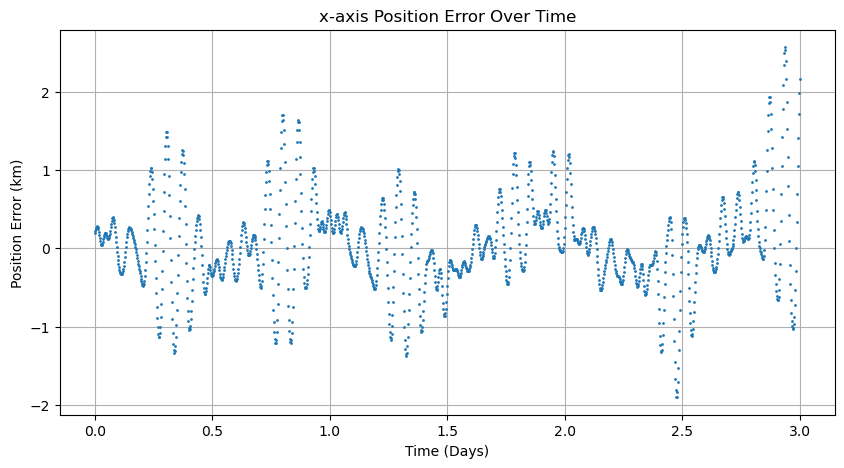

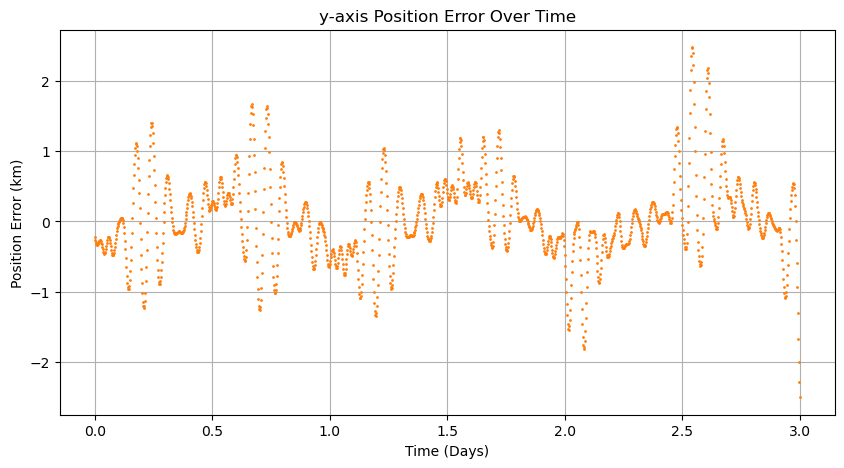

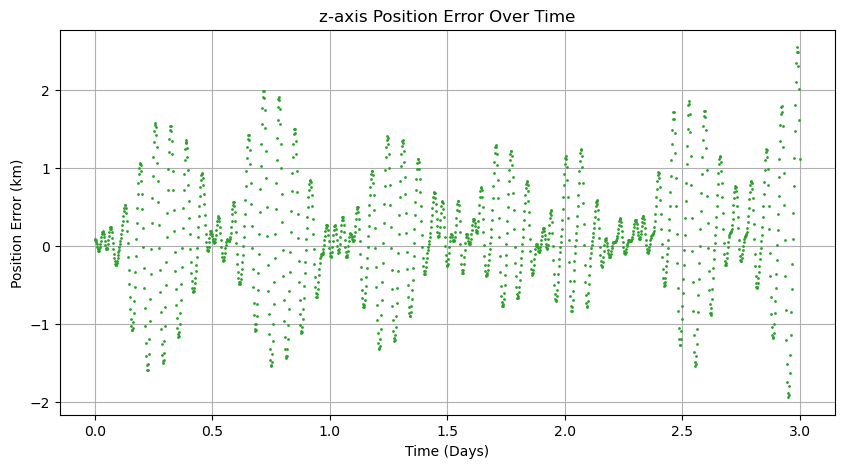

In [53]:
# Plot x-axis error
plt.figure(figsize=(10, 5))
plt.plot(time_days, (SGP4pos[:, 0] - SwarmApos[:, 0]) / 1000, '.', c="tab:blue", markersize=2)
plt.title("x-axis Position Error Over Time")
plt.xlabel('Time (Days)')
plt.ylabel('Position Error (km)')
plt.grid(True)
plt.show()

# Plot y-axis error
plt.figure(figsize=(10, 5))
plt.plot(time_days, (SGP4pos[:, 1] - SwarmApos[:, 1]) / 1000, '.', c="tab:orange", markersize=2)
plt.title("y-axis Position Error Over Time")
plt.xlabel('Time (Days)')
plt.ylabel('Position Error (km)')
plt.grid(True)
plt.show()

# Plot z-axis error
plt.figure(figsize=(10, 5))
plt.plot(time_days, (SGP4pos[:, 2] - SwarmApos[:, 2]) / 1000, '.', c="tab:green", markersize=2)
plt.title("z-axis Position Error Over Time")
plt.xlabel('Time (Days)')
plt.ylabel('Position Error (km)')
plt.grid(True)
plt.show()

### Kepler Propagator - 3D Vector Errors 

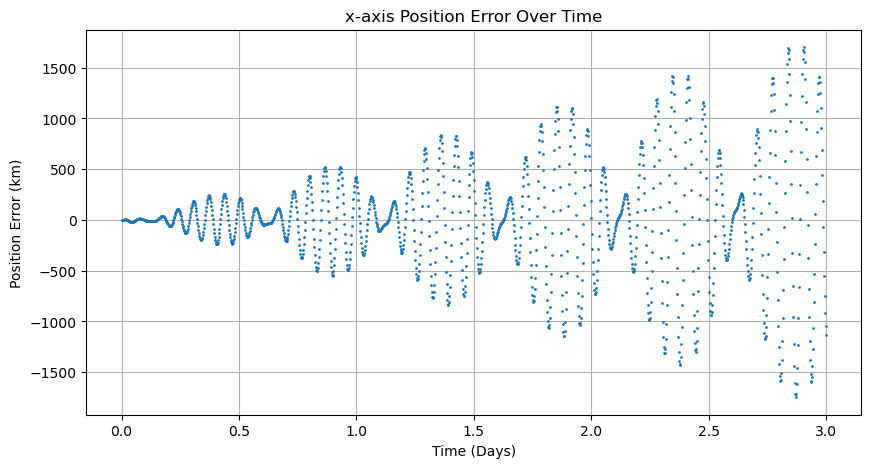

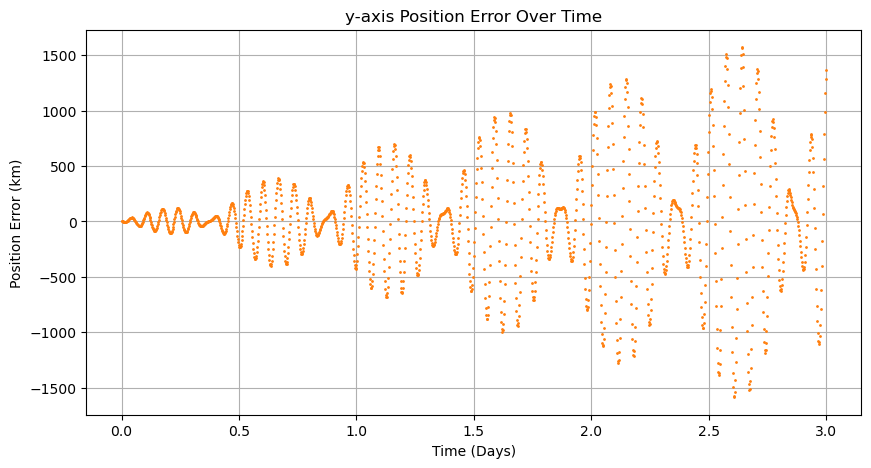

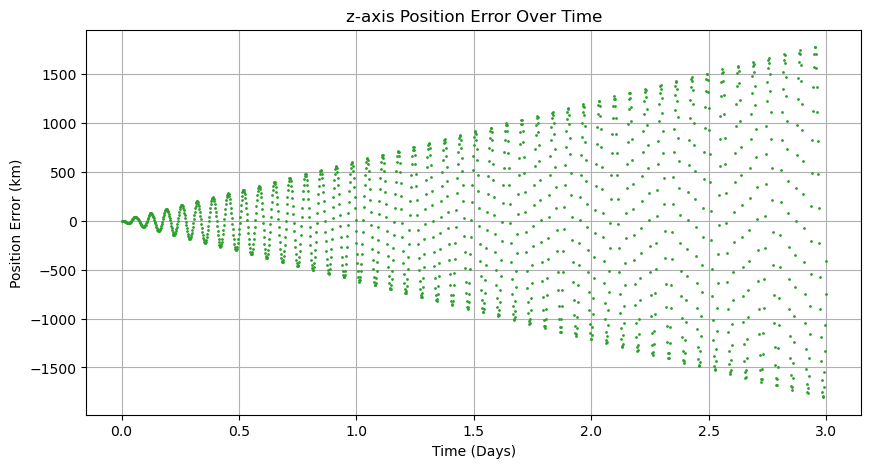

In [55]:
# Plot x-axis error
plt.figure(figsize=(10, 5))
plt.plot(time_days, (Keplerpos[:, 0] - SwarmApos[:, 0]) / 1000, '.', c="tab:blue", markersize=2)
plt.title("x-axis Position Error Over Time")
plt.xlabel('Time (Days)')
plt.ylabel('Position Error (km)')
plt.grid(True)
plt.show()

# Plot y-axis error
plt.figure(figsize=(10, 5))
plt.plot(time_days, (Keplerpos[:, 1] - SwarmApos[:, 1]) / 1000, '.', c="tab:orange", markersize=2)
plt.title("y-axis Position Error Over Time")
plt.xlabel('Time (Days)')
plt.ylabel('Position Error (km)')
plt.grid(True)
plt.show()

# Plot z-axis error
plt.figure(figsize=(10, 5))
plt.plot(time_days, (Keplerpos[:, 2] - SwarmApos[:, 2]) / 1000, '.', c="tab:green", markersize=2)
plt.title("z-axis Position Error Over Time")
plt.xlabel('Time (Days)')
plt.ylabel('Position Error (km)')
plt.grid(True)
plt.show()

### Eckstein-Heckler Propagator - 3D Vector Errors

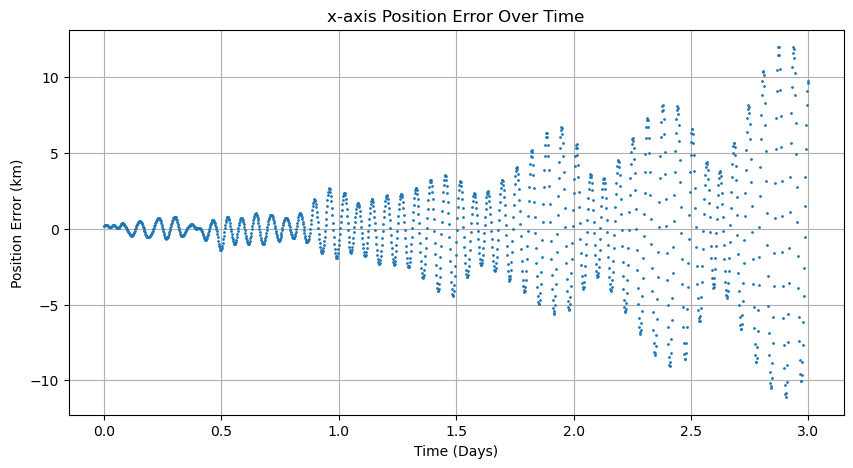

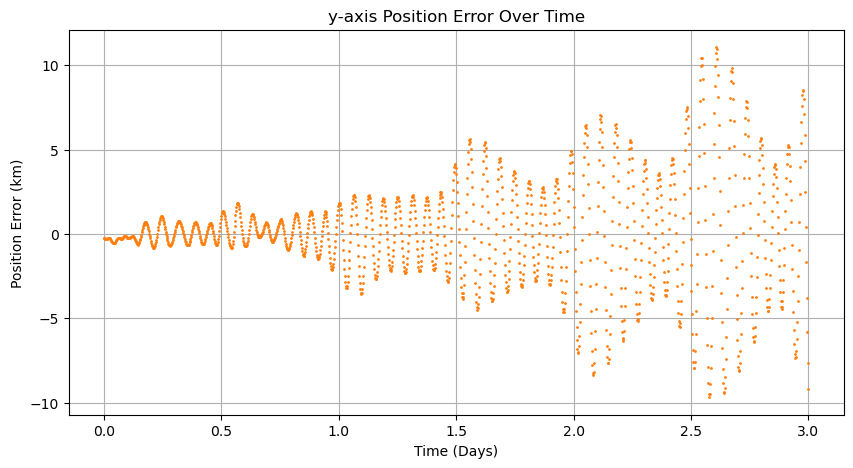

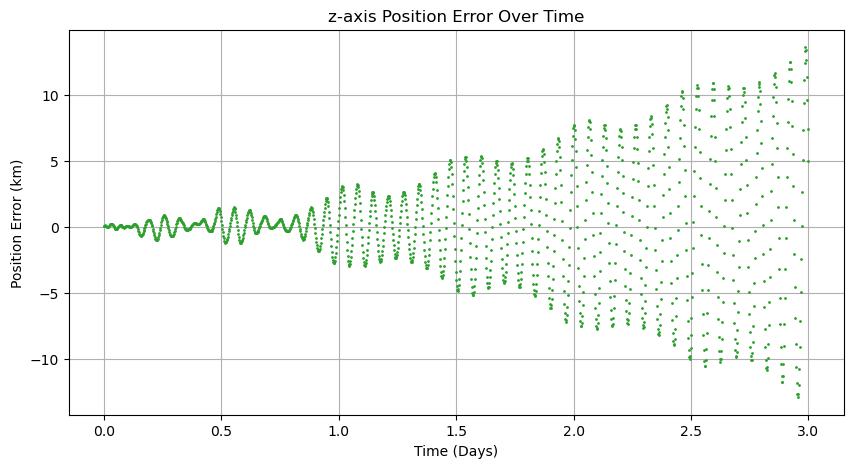

In [57]:
# Plot x-axis error
plt.figure(figsize=(10, 5))
plt.plot(time_days, (EHpos[:, 0] - SwarmApos[:, 0]) / 1000, '.', c="tab:blue", markersize=2)
plt.title("x-axis Position Error Over Time")
plt.xlabel('Time (Days)')
plt.ylabel('Position Error (km)')
plt.grid(True)
plt.show()

# Plot y-axis error
plt.figure(figsize=(10, 5))
plt.plot(time_days, (EHpos[:, 1] - SwarmApos[:, 1]) / 1000, '.', c="tab:orange", markersize=2)
plt.title("y-axis Position Error Over Time")
plt.xlabel('Time (Days)')
plt.ylabel('Position Error (km)')
plt.grid(True)
plt.show()

# Plot z-axis error
plt.figure(figsize=(10, 5))
plt.plot(time_days, (EHpos[:, 2] - SwarmApos[:, 2]) / 1000, '.', c="tab:green", markersize=2)
plt.title("z-axis Position Error Over Time")
plt.xlabel('Time (Days)')
plt.ylabel('Position Error (km)')
plt.grid(True)
plt.show()

###  Numerical Propagator - 3D Vector Errors

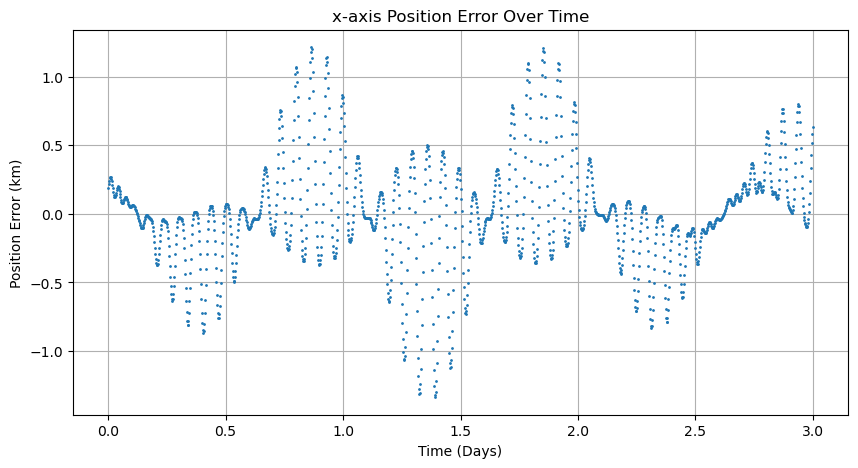

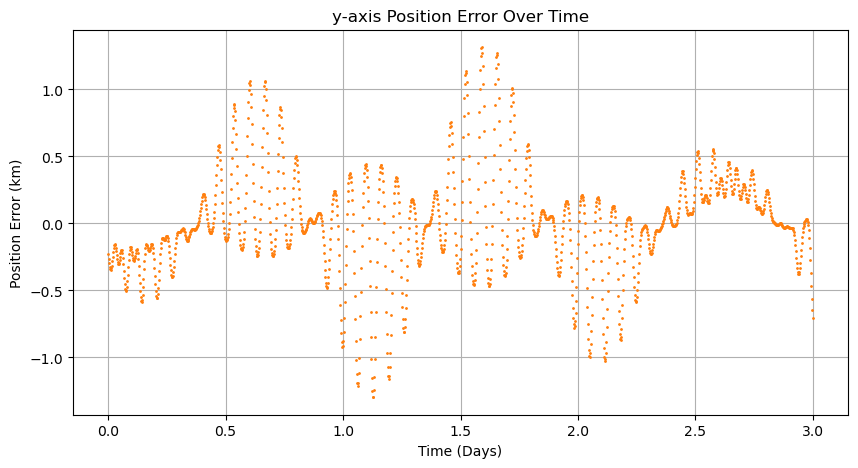

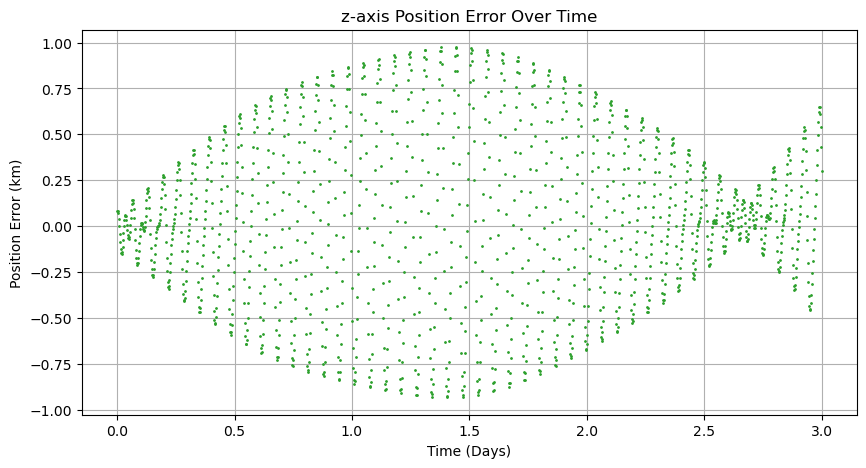

In [59]:
# Plot x-axis error
plt.figure(figsize=(10, 5))
plt.plot(time_days, (Numpos[:, 0] - SwarmApos[:, 0]) / 1000, '.', c="tab:blue", markersize=2)
plt.title("x-axis Position Error Over Time")
plt.xlabel('Time (Days)')
plt.ylabel('Position Error (km)')
plt.grid(True)
plt.show()

# Plot y-axis error
plt.figure(figsize=(10, 5))
plt.plot(time_days, (Numpos[:, 1] - SwarmApos[:, 1]) / 1000, '.', c="tab:orange", markersize=2)
plt.title("y-axis Position Error Over Time")
plt.xlabel('Time (Days)')
plt.ylabel('Position Error (km)')
plt.grid(True)
plt.show()

# Plot z-axis error
plt.figure(figsize=(10, 5))
plt.plot(time_days, (Numpos[:, 2] - SwarmApos[:, 2]) / 1000, '.', c="tab:green", markersize=2)
plt.title("z-axis Position Error Over Time")
plt.xlabel('Time (Days)')
plt.ylabel('Position Error (km)')
plt.grid(True)
plt.show()